In [1]:
from skimage import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request as urllib
from io import StringIO, BytesIO

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim
%matplotlib inline

In [2]:
tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.'
)

tf.flags.DEFINE_string(
    'checkpoint_path', 'inception_v3.ckpt', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', '', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', '', 'Output directory with images.')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

FLAGS = tf.flags.FLAGS

In [84]:
graph = tf.Graph()
with graph.as_default():   
    image_shape = (299, 299, 3)
    
    img_place = tf.placeholder(tf.float32, image_shape)
    fake_image_subst = tf.Variable(
        np.zeros(image_shape, dtype=np.float32),
    )
    fake_image = (tf.tanh(fake_image_subst) + 1) / 2
    
    assign_fake_image_subs = fake_image_subst.assign(
        tf.atanh(2 * img_place - 1)
    )
    
    sess = tf.Session()
    sess.run(assign_fake_image_subs, feed_dict={img_place: img})
    res = sess.run(fake_image)

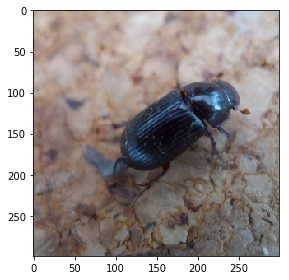

In [85]:
io.imshow(res)

In [4]:
DATASET_FOLDER = 'dataset'
DEV_DATASET_CSV = os.path.join(DATASET_FOLDER, 'dev_dataset.csv')
IMAGES_FOLDER = os.path.join(DATASET_FOLDER, 'images')

In [5]:
df = pd.read_csv(DEV_DATASET_CSV)
df.head(5)

,ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0,0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
1,f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
2,4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
3,cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
4,73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [6]:
def make_filename(img_id):
    return img_id + '.png'

def make_filepath(img_id):
    return os.path.join(IMAGES_FOLDER, make_filename(img_id))

def open_img(img_id):
    filepath = make_filepath(img_id)
    return io.imread(filepath)

def get_image_and_target(num):
    line = df.ix[num]
    
    url = line['URL']
    img_id = line['ImageId']
    
    return open_img(img_id) / 256, line['TargetClass'], line['TrueLabel']

In [132]:
img, target, label = get_image_and_target(1)

In [141]:
target, label

(378, 884)

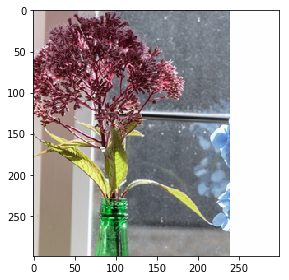

In [134]:
io.imshow(img)

In [135]:
target

378

In [142]:
class PushinMatyshin:
    def __init__(self):
        self.graph = tf.Graph()
        self.image_shape = (FLAGS.batch_size, 299, 299, 3)
        self.num_classes = 1001
        
        with self.graph.as_default():
            self.fake_image_subst = tf.Variable(
                np.zeros(self.image_shape, dtype=np.float32), name='fake_image_subst'
            )
            self.fake_image = (tf.tanh(self.fake_image_subst) + 1) / 2
        
            with slim.arg_scope(inception.inception_v3_arg_scope()):
                self.fake_logits, self.inception_end_points = inception.inception_v3(
                    self.fake_image, num_classes=self.num_classes, is_training=False,
                )
                
            self.softmaxed_fake = tf.nn.softmax(self.fake_logits)
            self.top_classes = tf.nn.top_k(self.softmaxed_fake, 3)
        
            self.real_image = tf.placeholder(tf.float32, self.image_shape, name='real_image')
            self.assign_fake_image = self.fake_image_subst.assign(self.real_image)
            self.assign_fake_image_subs = self.fake_image_subst.assign(
                tf.atanh(2 * self.real_image - 1)
            )
            self.target_probs = tf.placeholder(
                tf.float32, [FLAGS.batch_size, self.num_classes], name='target_probs'
            )
            self.max_perturbation = tf.placeholder(tf.float32, (), name='max_perturbation')
            self.alpha = tf.placeholder(tf.float32, (), name='alpha')
            self.learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

            self.main_loss = tf.losses.softmax_cross_entropy(
                self.target_probs,
                self.fake_logits,
                label_smoothing=0.1,
                weights=1.0
            )
            

            self.abs_img_diff = tf.abs(self.fake_image - self.real_image)
            self.clipped_img_diff = tf.where(
                    self.abs_img_diff > self.max_perturbation,
                    self.abs_img_diff, tf.zeros(self.image_shape)
                )
            self.clipped_diff_sum = tf.reduce_sum(self.clipped_img_diff)
            self.reg_loss = self.alpha * self.clipped_diff_sum

            self.loss = self.main_loss + self.reg_loss

            start_vars = set(x.name for x in tf.global_variables())
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            self.train = self.optimizer.minimize(self.loss, var_list=[self.fake_image_subst])
            
            end_vars = tf.global_variables()
            new_vars = [x for x in end_vars if x.name not in start_vars]
            self.init = tf.variables_initializer(var_list=[self.fake_image_subst] + new_vars)

            self.sess = tf.Session()
            saver = tf.train.Saver(slim.get_model_variables())
            saver.restore(self.sess, FLAGS.checkpoint_path)
    
    def inference(self, images, targets, max_perturbation=15, alpha=1, learning_rate=10**-3, n=10):
        target_probs = np.zeros((len(targets), self.num_classes))
        max_perturbation /= 256
        
        for number, target in enumerate(targets):
            target_probs[number][target] = 1
        
        with self.graph.as_default():
            self.sess.run(self.init)
            result_images = self.sess.run(
                [self.assign_fake_image, self.assign_fake_image_subs], feed_dict={self.real_image: images}
            )

            for i in range(n):
                result_images, loss, main_loss, reg_loss, softmaxed, fake_logits, top_classes, _ = self.sess.run(
                    [self.fake_image, self.loss, self.main_loss, self.reg_loss, self.softmaxed_fake, self.fake_logits, self.top_classes, self.train],
                    feed_dict={
                        self.real_image: images,
                        self.target_probs: target_probs,
                        self.max_perturbation: max_perturbation,
                        self.alpha: alpha,
                        self.learning_rate: learning_rate,
                    }
                )
                print(i, loss, main_loss, reg_loss, '\n', top_classes)
            return result_images, loss

In [143]:
pm = PushinMatyshin()

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


In [147]:
img, target, label = get_image_and_target(3)
target, label

(741, 560)

0 10.783 10.783 0.0 
 TopKV2(values=array([[ 0.8091206 ,  0.02469765,  0.02180064]], dtype=float32), indices=array([[560, 533, 766]], dtype=int32))
1 8.03364 8.03364 0.0 
 TopKV2(values=array([[ 0.1110777 ,  0.03225197,  0.01969005]], dtype=float32), indices=array([[533, 527, 560]], dtype=int32))
2 6.90717 6.90717 0.0 
 TopKV2(values=array([[ 0.02637977,  0.01770299,  0.01202456]], dtype=float32), indices=array([[560, 808, 766]], dtype=int32))
3 6.21016 6.21016 0.0 
 TopKV2(values=array([[ 0.0237387 ,  0.01740465,  0.01131076]], dtype=float32), indices=array([[560, 808, 707]], dtype=int32))
4 5.50963 5.50963 0.0 
 TopKV2(values=array([[ 0.02917704,  0.01917254,  0.01186215]], dtype=float32), indices=array([[808, 560, 707]], dtype=int32))
5 4.8873 4.8873 0.0 
 TopKV2(values=array([[ 0.02166451,  0.02044666,  0.01691348]], dtype=float32), indices=array([[808, 560, 707]], dtype=int32))
6 4.12294 4.12294 0.0 
 TopKV2(values=array([[ 0.02671118,  0.0259483 ,  0.02310274]], dtype=float32), i

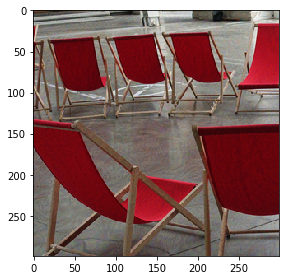

In [148]:
result, loss = pm.inference([img], [target], alpha=1, learning_rate=0.01, n=10)
io.imshow(result[0])

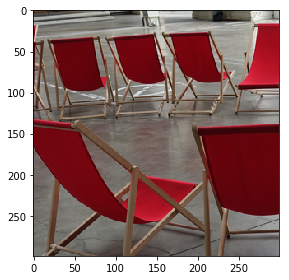

In [149]:
io.imshow(img)

In [151]:
img - result[0]

array([[[ -9.09918547e-03,   1.92314386e-02,   6.10119104e-03],
        [ -4.83930111e-03,   1.69262588e-02,   9.92840528e-03],
        [ -2.62238979e-02,   7.70816207e-03,   7.40888715e-03],
        ..., 
        [ -2.82214880e-02,  -3.24497223e-02,   7.37380981e-03],
        [ -3.27106118e-02,  -2.71918774e-02,   1.45984292e-02],
        [ -1.73103809e-02,   2.84827948e-02,   1.87479258e-02]],

       [[ -1.14002526e-02,   1.83068812e-02,   9.58687067e-03],
        [ -1.99818313e-02,  -1.98662877e-02,   5.32585382e-03],
        [ -2.33994126e-02,   1.24996305e-02,   8.07988644e-03],
        ..., 
        [ -1.28396153e-02,   1.72557831e-02,   1.80884004e-02],
        [ -9.33110714e-03,   1.61206722e-03,   2.00748444e-02],
        [ -6.08307123e-03,   1.87227726e-02,   2.02334523e-02]],

       [[ -1.50402188e-02,   1.38406157e-02,  -1.61888301e-02],
        [ -1.37073100e-02,   1.58371329e-02,   4.47648764e-03],
        [  3.23777795e-02,   1.73876882e-02,   1.08930767e-02],
        